In [1]:
:extension DerivingVia TypeFamilies DerivingStrategies GeneralizedNewtypeDeriving FlexibleContexts FlexibleInstances OverloadedStrings

import Prelude hiding ((*), (+))
import Diagrams.Prelude
import Control.Monad ((>=>))
import Data.Bifunctor (second, first)
import Data.Tuple (swap)
import Data.String (IsString)
import Data.List (partition, singleton)
import Data.Maybe (fromMaybe)
import IHaskell.Display.Diagrams
import Diagrams.Backend.Cairo (B)
import Data.Tree (Tree(Node), Forest, rootLabel, subForest, drawForest)
import Data.Semiring

### Type definitions

In [2]:
newtype Location = Location { name :: String } deriving newtype (Eq, Show, IsString)

data BellPair = Location :~: Location {- :~: is our symbol for entangled pair -}

instance Show BellPair where
    show (l1 :~: l2) = name l1 <> "," <> name l2 {- how BPs are displayed -}
instance Eq BellPair where
    l1 :~: l2 == l1' :~: l2' = (l1 , l2) == (l1', l2') || (l2, l1) == (l1', l2') 

infixl <||>

class Semigroup a => ParallelSemigroup a where {- define alg structure with <> inherited from semigroup and new <||> -}
    (<||>) :: a -> a -> a

class (ParallelSemigroup a) => Quantum a where {- Quantum is ParallelSemigroup -}
    tryCreateBellPairFrom :: BellPair -> [BellPair] -> Maybe Double -> a 
    {- tryCreateBellPairFrom is function from BP to sequence of BPs or maybe nothing -}

createBellPairFrom :: (Quantum a) => BellPair -> [BellPair] -> a
createBellPairFrom bp bps = tryCreateBellPairFrom bp bps Nothing {- createBellPairFrom is deterministic version of try..  -}


### Main policy definitions

In [3]:
data Policy {- define policy -}
    = Swap Location (Location, Location)
    | Transmit Location (Location, Location)
    | Distill (Location, Location)
    | Sequence Policy Policy
    | Parallel Policy Policy
    | Create Location deriving stock (Show)
    
    
instance Semigroup Policy where
    (<>) = Sequence

instance ParallelSemigroup Policy where
    (<||>) = Parallel

    


In [4]:
meaning :: (Quantum a) => Policy -> a  {-  methods -}
meaning (Swap l (l1, l2)) = createBellPairFrom (l1 :~: l2) [l :~: l1, l :~: l2]
meaning (Transmit l (l1, l2)) = createBellPairFrom (l1 :~: l2) [l :~: l]
meaning (Create l) = createBellPairFrom (l :~: l) []
meaning (Distill (l1, l2)) = tryCreateBellPairFrom (l1 :~: l2) [l1 :~: l2, l1 :~: l2] (Just 0.5)
meaning (Sequence p q) = meaning p <> meaning q
meaning (Parallel p q) = meaning p <||> meaning q

### History of Bell pairs

In [5]:
newtype History = History { getForest :: Forest BellPair } deriving newtype (Show, Semigroup, Monoid) 

In [6]:
findTreeRoot :: BellPair -> History -> Maybe (Tree BellPair, History)
findTreeRoot p (History ts) =
    case partition ((== p) . rootLabel) ts of
        (t:ts, ts') -> Just (t, History (ts <> ts'))
        _ -> Nothing

findTreeRoots :: [BellPair] -> History -> Maybe (Forest BellPair, History)
findTreeRoots [] h = Just ([], h)
findTreeRoots (p : ps) h = findTreeRoot p h >>= \(t, h) ->
    findTreeRoots ps h >>= \(ts, h) -> return (t : ts, h)
    
findSubHistory :: [BellPair] -> History -> Maybe (History, History)
findSubHistory ps h = first History <$> findTreeRoots ps h

findSubHistory' :: [BellPair] -> History -> (Maybe History, History)
findSubHistory' ps h = maybe (Nothing, h) (first return) $ findSubHistory ps h

dup :: History -> History
dup = History . map (\t -> Node (rootLabel t) [t]) . getForest

In [7]:
data HistoryQuantum = HistoryQuantum 
    { requiredRoots :: [BellPair]
    , execute :: History -> [History] 
    }
        
executePartial :: HistoryQuantum -> History -> ([History], History)
executePartial hq h = 
    case findSubHistory (requiredRoots hq) h of
        Nothing -> ([History[]], h)
        Just (hInput, hRest) -> (execute hq hInput, hRest)

In [8]:
instance Semigroup HistoryQuantum where
    hq <> hq' = HistoryQuantum 
        { requiredRoots = requiredRoots hq
        , execute = execute hq >=> execute hq'
        }
    
instance ParallelSemigroup HistoryQuantum where
    hq <||> hq' = HistoryQuantum
        { requiredRoots = requiredRoots hq <> requiredRoots hq'
        , execute = \h -> 
            let (hs, hRest) = executePartial hq h
                (hs', hRest') = executePartial hq' hRest
            in [dup hRest' <> hNew <> hNew' | hNew <- hs , hNew' <- hs']
        }
    
instance Quantum HistoryQuantum where
    tryCreateBellPairFrom p bp prob = HistoryQuantum 
        { requiredRoots = bp
        , execute = \h -> fromMaybe [dup h] $ findTreeRoots bp h >>= \(ts, h) -> return $
            case prob of 
                Nothing -> [dup h <> History [Node p ts]]
                Just _ -> [dup h <> History [Node p ts], dup h]
        }

In [9]:
applyPolicy :: Policy -> History -> [History]
applyPolicy = execute . meaning

### Some drawing code

In [10]:
pairToDiagram bp = (text (show bp) <> rect 4 1) # fontSize (local 0.5) 

treeToDiagram t = 
    let childrenNames = [1..(length $ subForest t :: Int)]
        rootName = 0 :: Int
        subtrees = zipWith (.>>) childrenNames (map treeToDiagram $ subForest t)
      in vsep 1 [pairToDiagram (rootLabel t) # named rootName, hsep 0.5 subtrees # centerX  ] 
          # appEndo (mconcat $ map (\i -> Endo $ connectOutside (i .> rootName) rootName) childrenNames)

historyToDiagram (History ts) = hsep 0.5 (map treeToDiagram ts)

drawPolicy :: Policy -> ManuallySized (Diagram B)
drawPolicy p = withImgWidth 600 . vsep 1 . fmap historyToDiagram . applyPolicy p $ History [] 

## Examples

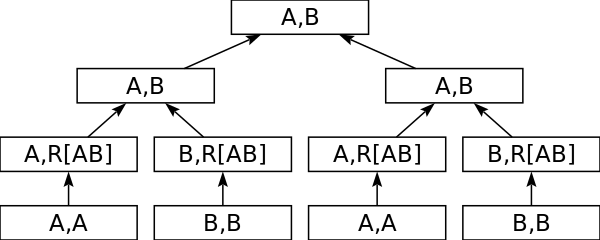

In [11]:
p = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
    
drawPolicy $ (p <||> p) <> Distill ("A", "B")

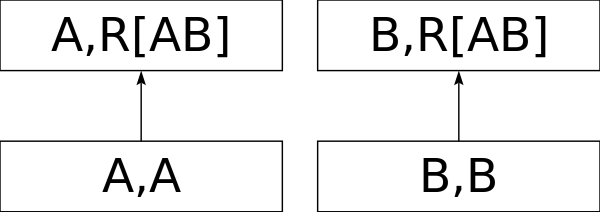

In [12]:
drawPolicy $ (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]"))

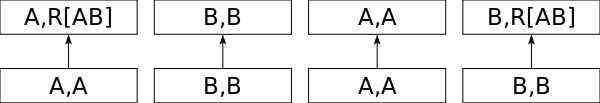

In [13]:
drawPolicy $ 
    (Create "A" <> Transmit "A" ("A", "R[AB]")) 
    <||> (Create "B" <> Transmit "A" ("A", "R[AB]")) 
    <||> (Create "A" <> Transmit "B" ("B", "R[AB]"))
    <||> (Create "B" <> Transmit "B" ("B", "R[AB]"))

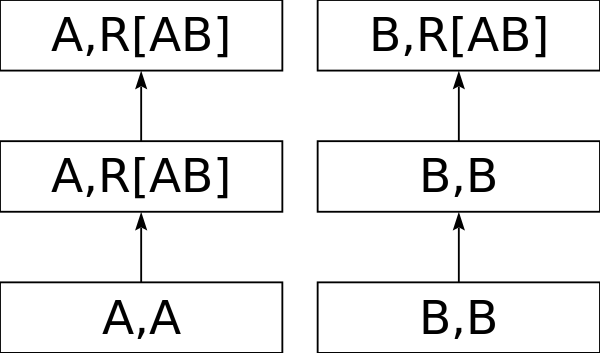

In [14]:
drawPolicy $ 
    (Create "A" <||> Create "B") <> Transmit "A" ("A", "R[AB]") <> Transmit "B" ("B", "R[AB]")

Line 5: Redundant bracket
Found:
(Transmit "B" ("B", "R[AB]") <||> Create "B")
  <> (Swap "R[AB]" ("A", "B"))
Why not:
(Transmit "B" ("B", "R[AB]") <||> Create "B")
  <> Swap "R[AB]" ("A", "B")

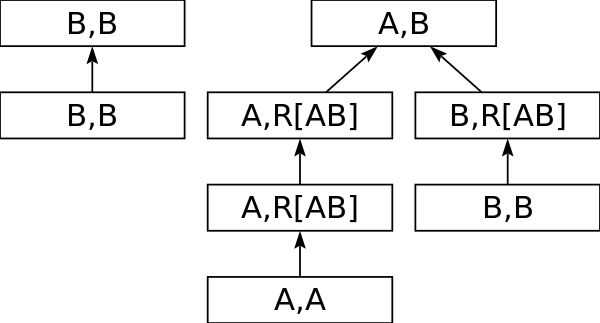

In [15]:
drawPolicy $ 
    Create "A"
    <> (Transmit "A" ("A", "R[AB]") <||> Create "B") 
    <> (Transmit "B" ("B", "R[AB]") {- <||> Identity ("A", "R[AB]") -} <||> Create "B")
    <> (Swap "R[AB]" ("A", "B") {- <||> Identity ("B", "B") -})

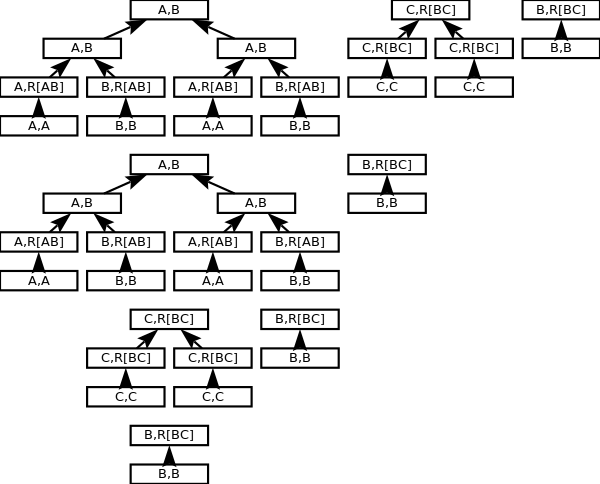

In [16]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")

drawPolicy $ ((pAB <||> pAB) <> Distill ("A", "B")) <||> (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]")) )

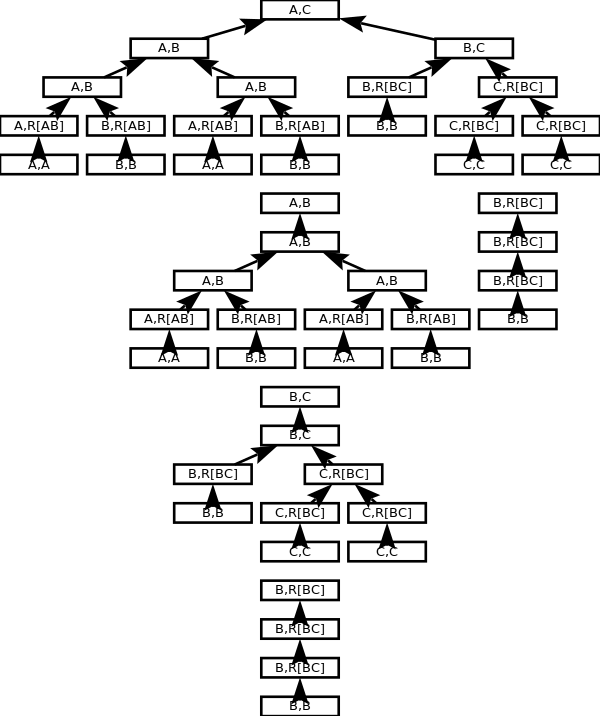

In [17]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")
pBC = (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]"))) <> Swap "R[BC]" ("B", "C")


drawPolicy $ (((pAB <||> pAB) <> Distill ("A", "B")) <||> pBC ) <> Swap "B" ("A", "C")

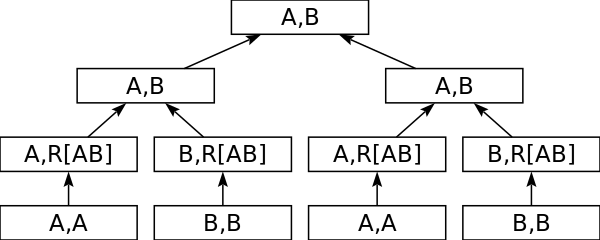

In [18]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")
pBC = (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]"))) <> Swap "R[BC]" ("B", "C")

drawPolicy ((pAB <||> pAB) <> Distill ("A", "B"))

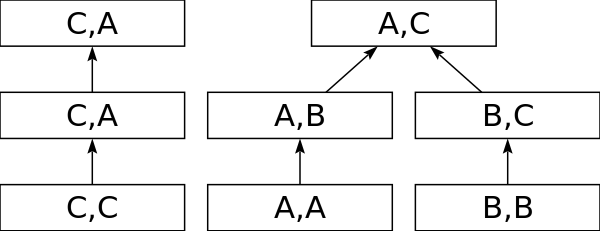

In [22]:
drawPolicy $ (Create "A" <||> Create "B" <||> Create "C") <> (Transmit "A" ("A", "B") <||> Transmit "B" ("B", "C") <||> Transmit "C" ("C", "A")) <> Swap "B" ("A", "C")

## Question

 * Show failures as part of the history? Could be too much of information?
 * Failures in distill and swap?
 * reachability in practice (only with some probability)
 * Simulating the actual run of the policy?
 * Generate the policy from probability